In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 13 09:37:07 2022

@author: Aaron Sigman

Hydroinfo: HW7

This code retrieves stream info from nwis.
You can input site, parameters, and dates at the top
This pulls Daily measurements, annual_stats, and daily_stats, 
plotting 
-annual average flows, with 30-yr normals
-annual max, min, mean
-percentile flows
"""
from dataretrieval import nwis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
Site="09163500"
Param="00060"
Stat="None"
StartDay='1970-01-01'
EndDay='2021-12-31'
StartYr='1970'
EndYr='2021'

In [3]:
Daily=nwis.get_dv(sites=Site,parameterCd=Param,start=StartDay,end=EndDay)

annual_stats = nwis.get_stats(sites=Site,
                              parameterCd=Param,
                              statReportType='annual',
                              startDt=StartYr,
                              endDt=EndYr)

daily_stats = nwis.get_stats(sites=Site,
                              parameterCd=Param,
                              statReportType='daily',
                              startDt=StartYr,
                              endDt=EndYr)


In [4]:
low_flow_years = annual_stats[0].nsmallest(5, 'mean_va')
high_flow_years = annual_stats[0].nlargest(5, 'mean_va')

# Find the lowest and highest flows and years of flow.
min_flow = low_flow_years['mean_va'].min()
min_flow_yr = low_flow_years['year_nu'][low_flow_years['mean_va'].idxmin()]
max_flow = high_flow_years['mean_va'].max()
max_flow_yr = high_flow_years['year_nu'][high_flow_years['mean_va'].idxmax()]
print('Lowest average annual streamflow was %s cfs in %s' % (min_flow, min_flow_yr))
print('Highest average annual streamflow was %s cfs in %s' % (max_flow, max_flow_yr))
print(low_flow_years)
# The annual stats only gives the annual mean. Use the daily values to calculate the annual min, max, mean.
# Investigate the resample() function/method.
annual_stats_calc = pd.DataFrame()
annual_stats_calc['mean'] = Daily[0]['00060_Mean'].resample(rule='1Y').mean()
annual_stats_calc['min'] = Daily[0]['00060_Mean'].resample(rule='1Y').min()
annual_stats_calc['max'] = Daily[0]['00060_Mean'].resample(rule='1Y').max()

print("2021's average streamflow was %.0f cfs"%annual_stats_calc['mean'][-1])
print("2021's minimum streamflow was %.0f cfs"%annual_stats_calc['min'][-1])
print("2021's maximum streamflow was %.0f cfs"%annual_stats_calc['max'][-1])


Lowest average annual streamflow was 2212 cfs in 1977
Highest average annual streamflow was 13770 cfs in 1984
   agency_cd   site_no  parameter_cd  ts_id  loc_web_ds  year_nu  mean_va  \
7       USGS  09163500            60  19083         NaN     1977     2212   
32      USGS  09163500            60  19083         NaN     2002     2264   
42      USGS  09163500            60  19083         NaN     2012     2882   
48      USGS  09163500            60  19083         NaN     2018     3092   
20      USGS  09163500            60  19083         NaN     1990     3098   

    count_nu  
7        365  
32       365  
42       366  
48       365  
20       365  
2021's average streamflow was 2904 cfs
2021's minimum streamflow was 1810 cfs
2021's maximum streamflow was 7770 cfs


In [5]:
# Get 30 yr averages
Years=list(annual_stats[0]['year_nu']) # get list of years
Num_Years=len(Years) # how many total years
Interval=30 # set length of average
Every=10 # set how often you want average
x=0 # to remember which interval the loop is on
Normals_yr=[]
Normals_30=[]
while x<=(Num_Years-Interval):
    Normals_30.append(np.mean(annual_stats[0][0+x:Interval+x]['mean_va']))
    Normals_yr.append([np.min(annual_stats[0][0+x:Interval+x]['year_nu']),np.max(annual_stats[0][0+x:Interval+x]['year_nu'])])
    x+=Every


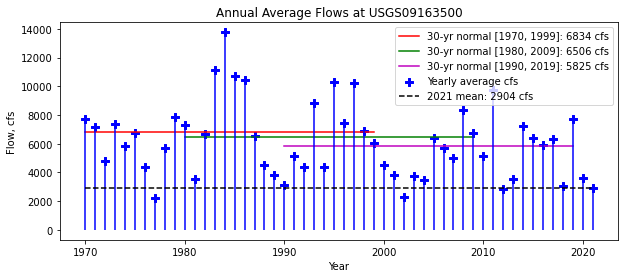

In [6]:
# Plot the annual mean points for each year, with 30 yr averages, comparing to 2021
plt.figure(figsize=(10,4)) 
# Set colors for 30yr normal lines, can be up to four averages
Colors=['r','g','m','c']
# Plot all normal lines
for i in range(len(Normals_30)):
    plt.plot(Normals_yr[i],[Normals_30[i],Normals_30[i]],label='30-yr normal %s: %.0f cfs'%(Normals_yr[i],Normals_30[i]),color=Colors[i])
# Plot annual average with vertical lines
plt.scatter(annual_stats_calc.index.year, annual_stats_calc['mean'],  marker='P', s=70, label='Yearly average cfs',color='b')
plt.vlines(x=annual_stats_calc.index.year, ymin=0, ymax=annual_stats_calc['mean'],color='b')
plt.plot([annual_stats_calc.index.year[0],annual_stats_calc.index.year[-1]],[annual_stats_calc['mean'][-1],annual_stats_calc['mean'][-1]],'k--',label='2021 mean: %.0f cfs'%annual_stats_calc['mean'][-1])
plt.legend();plt.title('Annual Average Flows at USGS'+Site)
plt.xlabel('Year');plt.ylabel('Flow, cfs');plt.show()


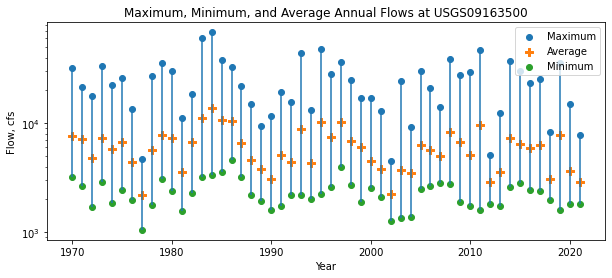

In [7]:
# Plot the annual min, max, mean as points for each year with vertical lines to illustrate the annual range.
plt.figure(figsize=(10, 4))
plt.vlines(x=annual_stats_calc.index.year, ymin=annual_stats_calc['min'], ymax=annual_stats_calc['max'])
plt.scatter(annual_stats_calc.index.year, annual_stats_calc['max'], label='Maximum')
plt.scatter(annual_stats_calc.index.year, annual_stats_calc['mean'],  marker='P', s=70, label='Average')
plt.scatter(annual_stats_calc.index.year, annual_stats_calc['min'], label='Minimum')
plt.legend();plt.title("Maximum, Minimum, and Average Annual Flows at USGS"+Site)
plt.ylabel('Flow, cfs');plt.yscale('log');plt.xlabel('Year');plt.show()


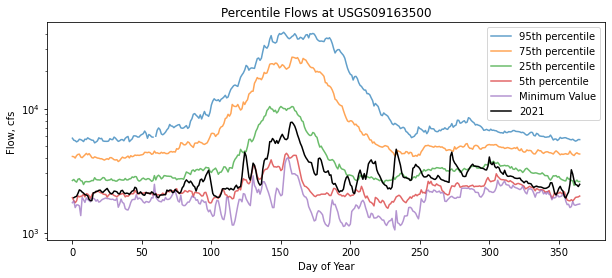

In [8]:
# Get 2021's daily values
Daily_2021=Daily[0][Daily[0].index.year>2020]
# Plot percentiles graph, lowering opacity of percentiles to show current year more boldly
plt.figure(figsize=(10, 4))
plt.plot(daily_stats[0]['p95_va'], label='95th percentile',alpha=.7)
plt.plot(daily_stats[0]['p75_va'], label='75th percentile',alpha=.7)
plt.plot(daily_stats[0]['p25_va'], label='25th percentile',alpha=.7)
plt.plot(daily_stats[0]['p05_va'], label='5th percentile',alpha=.7)
plt.plot(daily_stats[0]['min_va'], label='Minimum Value',alpha=.7)
plt.plot(Daily_2021.index.dayofyear,Daily_2021['00060_Mean'],'k',label='2021')
plt.title('Percentile Flows at USGS'+Site)
plt.ylabel('Flow, cfs');plt.yscale('log');plt.xlabel('Day of Year')
plt.legend();plt.show()